# Preparation

In [1]:
import iminuit
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('notebook')

# Load C14 models

In [3]:
import c14_models

# Read patient data

In [5]:
c14_patient_data = pd.read_pickle('./data/C14data_liver_samples_20180505.pkl')

In [6]:
exp_data = c14_patient_data.query('valid').copy()
exp_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,subject_age,valid
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,73.583333,True
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,25.416667,True
2,hepatocyte,PH3,ND381,1985.166667,2016.416667,0.040336,31.250000,True
3,hepatocyte,PH4,ND382,1982.083333,2016.500000,0.018815,34.416667,True
4,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,58.333333,True


In [7]:
exp_data.describe()

,Dbirth,Dcoll,d14C,subject_age
count,78.000000,78.000000,78.000000,78.000000
mean,1961.997863,2016.506410,0.042786,54.508547
std,20.084772,2.754433,0.022503,19.823475
min,1932.583333,2004.833333,0.005100,20.000000
25%,1946.000000,2016.750000,0.026672,37.500000
50%,1958.750000,2017.208333,0.040768,58.250000
75%,1979.833333,2017.416667,0.051100,68.854167
max,1997.333333,2017.583333,0.131107,84.666667


# Plot data 

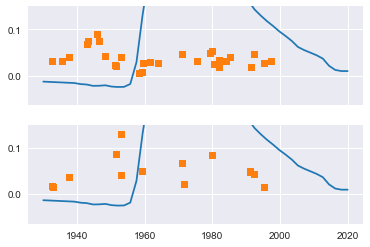

In [18]:
fig, axs = plt.subplots(2, sharex=True, sharey=True)
tt = np.linspace(1930, 2020)

for ax, data in zip(axs, 
                    [exp_data.query('type == "hepatocyte"'), exp_data.query('type == "non-hepatocyte"')]):

    ax.plot(tt, np.vectorize(c14_models.C_atm)(tt))
    ax.plot(data['Dbirth'], data['d14C'], ls = 'None', marker = 's')
ax.set_ylim(None, 0.15)
plt.show()

# SSE & log-likelihood

In [19]:
def SSE(p, model, data):
    model_data = model(data['Dbirth'].values, 
                    data['Dcoll'].values, 
                    *p)
    sse = np.sum((model_data - data['d14C'].values)**2)
    return sse    

In [20]:
def Sigma(p, model, data):
    sse = SSE(p, model, data)
    n = len(data)
    sigma = np.sqrt(sse/n)
    return sigma

In [21]:
def Nloglike(p, model, data):
    try:
        sse = SSE(p, model, data)
    except:
        sse = SSE([p], model, data)
    n = len(data)
    sig = np.sqrt(sse/n)
    loglike = -n/2 * np.log(2*np.pi) - n/2 * np.log(sig**2) - 1 / (2*sig**2) * sse
    return -loglike

# Scenario I1

In [22]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    if loglam <= 10:
        lam = np.exp(loglam)
        return c14_models.C_scenario_A(Dbirth, Dcoll, lam)
    else:
        return c14_models.C_atm(Dcoll)

## Fit

In [44]:
M_hepa = iminuit.Minuit(lambda loglam: Nloglike(loglam, I1, exp_data.query('type == "hepatocyte"')),
                       loglam=np.log(0.1), error_loglam=np.log(0.01),
                       errordef=1)
_ = M_hepa.migrad()
_ = M_hepa.minos(sigma=1.96)

FCN = -83.02076743492756 
 TOTAL NCALL = 45 
 NCALLS = 45 
 
 
 EDM = 1.0688564320275618e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,loglam,-1.54698,0.0887828,0,0,,,


Error,-0.2737729024692561,0.4054791964600205
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


In [46]:
M_nonhepa = iminuit.Minuit(lambda loglam: Nloglike(loglam, I1, exp_data.query('type == "non-hepatocyte"')),
                       loglam=np.log(0.1), error_loglam=np.log(0.01),
                       errordef=1)
_ = M_nonhepa.migrad()
_ = M_nonhepa.minos(sigma=1.96)

FCN = -28.447044825030133 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 1.074861879766613e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,loglam,-2.10248,0.0895999,0,0,,,


Error,-0.44778558772337246,0.9925029058827104
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


## Extract values

In [61]:
def lam_estimate(M):
    lam = np.exp(M.values['loglam'])
    lam_min = np.exp(M.values['loglam'] + M.merrors[('loglam', -1.0)])
    lam_max = np.exp(M.values['loglam'] + M.merrors[('loglam', 1.0)])
    return lam, lam_min, lam_max

In [69]:
lam_hepa, lam_hepa_min, lam_hepa_max = lam_estimate(M_hepa)
sigma_hepa = Sigma([np.log(lam_hepa)], I1, exp_data.query('type == "hepatocyte"'))

lam_nonhepa, lam_nonhepa_min, lam_nonhepa_max = lam_estimate(M_nonhepa)
sigma_nonhepa = Sigma([np.log(lam_nonhepa)], I1, exp_data.query('type == "non-hepatocyte"'))

# Print

In [73]:
print('Turnover rate')
print('Hepatocytes')
print('lambda (per year): {:.2f} [{:.2f}, {:.2f}]'.format(lam_hepa, lam_hepa_min, lam_hepa_max))

print('Non-Hepatocytes')
print('lambda (per year): {:.2f} [{:.2f}, {:.2f}]'.format(lam_nonhepa, lam_nonhepa_min, lam_nonhepa_max))

Turnover rate
Hepatocytes
lambda (per year): 0.21 [0.16, 0.32]
Non-Hepatocytes
lambda (per year): 0.12 [0.08, 0.33]


#  Plot Results

In [88]:
sns.set_context('paper', font_scale=1.5)

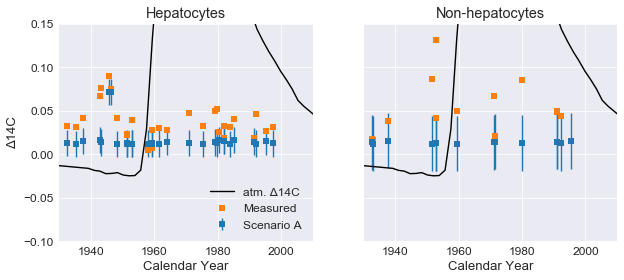

In [112]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
tt = np.linspace(1930, 2020)

for ax, data, lam, sigma, title in zip(axs, 
                    [exp_data.query('type == "hepatocyte"'), exp_data.query('type == "non-hepatocyte"')],
                        [lam_hepa, lam_nonhepa],
                        [sigma_hepa, sigma_nonhepa],
                                      ['Hepatocytes', 'Non-hepatocytes']):

    ax.plot(tt, np.vectorize(c14_models.C_atm)(tt), color='k', label=u'atm. Δ14C')
    ax.errorbar(data['Dbirth'], I1(data['Dbirth'], data['Dcoll'], lam), sigma, ls='None', marker='s',
               label='Scenario A')
    ax.plot(data['Dbirth'], data['d14C'], ls = 'None', marker = 's',
           label='Measured')
    
    ax.set_xlabel('Calendar Year')
    ax.set_title(title)
    
axs[0].set_ylabel(u'Δ14C')
ax.set_xlim(1930, 2010)
ax.set_ylim(-0.1, 0.15)
axs[0].legend(loc = 'lower right')
plt.savefig('./plots/scenario_A.png', dpi=300)
plt.savefig('./plots/scenario_A.svg')
plt.show()